# Helpful Reviews

### Data Wrangling

### Corey J Wade, WM^3

## Introduction

This Jupyter Notebook will present data wrangling on the Amazon Book Reviews dataset courtesy of Julian McAuley, UCSC: 

http://jmcauley.ucsd.edu/data/amazon/

Our goal is to create a new metric, Helpful Rating, that can be generated immediately after a review is written.

## Open Dataset

In [1]:
# Import essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Show all plots in cells
%matplotlib inline

# Open DataFrame
df = pd.read_csv('Amazon_Data_Frame.csv')

# View DataFrame
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,000100039X,"[0, 0]",5.0,Spiritually and mentally inspiring! A book tha...,"12 16, 2012",A10000012B7CGYKOMPQ4L,Adam,Wonderful!,1355616000
1,1,000100039X,"[0, 2]",5.0,This is one my must have books. It is a master...,"12 11, 2003",A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",close to god,1071100800
2,2,000100039X,"[0, 0]",5.0,This book provides a reflection that you can a...,"01 18, 2014",A1BM81XB4QHOA3,"Ahoro Blethends ""Seriously""",Must Read for Life Afficianados,1390003200
3,3,000100039X,"[0, 0]",5.0,I first read THE PROPHET in college back in th...,"09 27, 2011",A1MOSTXNIO5MPJ,Alan Krug,Timeless for every good and bad time in your l...,1317081600
4,4,000100039X,"[7, 9]",5.0,A timeless classic. It is a very demanding an...,"10 7, 2002",A2XQ5LZHTD4AFT,Alaturka,A Modern Rumi,1033948800


## Delete Unnamed Column

In [2]:
# Delete extraneous column
del df['Unnamed: 0']

## Column Info

In [3]:
# Get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898041 entries, 0 to 8898040
Data columns (total 9 columns):
asin              object
helpful           object
overall           float64
reviewText        object
reviewTime        object
reviewerID        object
reviewerName      object
summary           object
unixReviewTime    int64
dtypes: float64(1), int64(1), object(7)
memory usage: 611.0+ MB


Note that the number of non-null objects for each column are not shown for a dataset this large.

## Delete NaN Reviews

In [4]:
# Count number of reviews with no text
df['reviewText'].isnull().sum()

591

In [5]:
# Delete reviews with no text
df = df.dropna(axis=0, subset=['reviewText'])

In [6]:
# Check that rows have been deleted
df['reviewText'].isnull().sum()

0

## Convert Helpful List

In [7]:
# Convert 'helpful' column to list
import ast
helpful_List = np.array(df.helpful.apply(lambda row: ast.literal_eval(row)).tolist())

# Separate list into distinct columns
df['Helpful_Votes'] = helpful_List[:,0]
df['Total_Votes'] = helpful_List[:,1]

## Create Helpful_Percentage

In [8]:
# Create column for helpful percentage, convert NaN values to 0
df['Helpful_Percentage'] = (df['Helpful_Votes']/df['Total_Votes']).fillna(0)

In [9]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Helpful_Votes,Total_Votes,Helpful_Percentage
0,000100039X,"[0, 0]",5.0,Spiritually and mentally inspiring! A book tha...,"12 16, 2012",A10000012B7CGYKOMPQ4L,Adam,Wonderful!,1355616000,0,0,0.000000
1,000100039X,"[0, 2]",5.0,This is one my must have books. It is a master...,"12 11, 2003",A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",close to god,1071100800,0,2,0.000000
2,000100039X,"[0, 0]",5.0,This book provides a reflection that you can a...,"01 18, 2014",A1BM81XB4QHOA3,"Ahoro Blethends ""Seriously""",Must Read for Life Afficianados,1390003200,0,0,0.000000
3,000100039X,"[0, 0]",5.0,I first read THE PROPHET in college back in th...,"09 27, 2011",A1MOSTXNIO5MPJ,Alan Krug,Timeless for every good and bad time in your l...,1317081600,0,0,0.000000
4,000100039X,"[7, 9]",5.0,A timeless classic. It is a very demanding an...,"10 7, 2002",A2XQ5LZHTD4AFT,Alaturka,A Modern Rumi,1033948800,7,9,0.777778


#### Error Check

Check for Helpful Percentage above 100%S. 

In [10]:
len(df[df['Helpful_Percentage']>1.0])

15

#### Drop Errors

In [11]:
df = df.drop(df[df['Helpful_Percentage']>1.0].index)

In [12]:
len(df[df['Helpful_Percentage']>1.0])

0

## Delete No Vote Rows

We are only interested in reviews that received a thumbs up or thumbs down since they can be trained and tested. If the review contains no votes, it should be eliminated.

In [13]:
# Find number of rows with 0 votes
len(df[df['Total_Votes']==0])

4141097

In [14]:
# Copy original dataframe
df_original = df

# Drop rows with 0 votes from data frame
df = df.drop(df[df['Total_Votes']==0].index)

In [15]:
# Check drop
len(df[df['Total_Votes']==0])

0

In [16]:
df.to_csv('amzn_df_dw_initial.csv')

## Add Columns Analyzing Text

Even though words in a bag, sentiment analysis, and/or other approved text analysis may be applied later, I want to add a couple of relevant columns.

In [17]:
# import regular expressions, string
import re
import string

def average_sentence_length(text):
    # choose endings to split sentences with re
    sentence_endings = r"[.?!]"
    # use spaces to separate words with re
    spaces = r"\s+"
    
    # split sentences
    sentences = re.split(sentence_endings, text)
    # filter out blanks (occurs after last punctuation mark)
    sentences = list(filter(None, sentences))
    
    count = 0.0
    for sentence in sentences:
        # split sentence into individual words
        words = re.split(spaces, sentence)
        # filter out empty words
        words = list(filter(None, words))
        # add word count
        count += len(words)
    return count/len(sentences)


def average_word_length(text):
    
    # prepare punctuation strip with re
    strip = re.compile('[%s]' % re.escape(string.punctuation))
    
    # remove punctuation from text
    words = strip.sub('', text)

    # use spaces to separate words with re
    spaces = r"\s+"
    
    # split sentences into list of words
    words = re.split(spaces, words)
    
    count = 0
    for word in words:
        # count length of each word
        count += len(word)
    return count/len(words)

In [18]:
# Create column for length of review
df['Review_Length'] = df['reviewText'].str.len()

# Create column for average length of sentence
df['Sentence_Length'] = df['reviewText'].apply(average_sentence_length)

# Create column for average word length
df['Word_Length'] = df['reviewText'].apply(average_word_length)

In [19]:
df.to_csv('amzn_df_dw_newcols.csv')

In [20]:
df.Helpful_Votes.describe()

count    4.756338e+06
mean     5.625667e+00
std      2.663631e+01
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      2.331100e+04
Name: Helpful_Votes, dtype: float64

In [21]:
df = df.reset_index()

## Create Target Column: Helpful Rating

There is no column to measure how helpful a particular review is. Creating such a column is essential because it will determine my target variable.

In order to create a new function to scale Helpful_Votes from (0,1), I first need a function for a straight line.

#### Straight Line Function

In [22]:
# Define line from two points and a provided column
def two_points_line(a, b, column):
        
    # Case when y-values are the same
    if b[1]==a[1]:
        
        # Slope defaults to 0
        slope = 0
        
    # Case when x-values are the same
    elif b[0]==a[0]:
        
        # Case when max value is less than 999999999
        if column.max() < 999999999:
            
            # Add 999999999 to max value
            slope = column.max() + 999999999
        
        # All other cases
        else:
            
            # Multiply max value by itself (greater than 999999999)
            slope = column.max() * column.max()
    
    # When x-values and y-values are not 0
    else:
        
        # Use standard slope formula
        slope = (b[1] - a[1])/(b[0]-a[0])
    
    
    # Equation for y-intercept (solving y=mx+b for b)
    y_int = a[1] - slope * a[0]
    
    # Return slope and y-intercept
    return slope, y_int

#### Piecewise Linear Function

Next I will define a piecewise linear function to transform Helpful_Votes into the desired column.

In [23]:
# Transform skewed column into piecewise linear function by choosing number of segments
def skewed_to_linear(num_segments, column, logspace=True, rightSkew=True, show_graph=True, print_arrays=False, nonNegative=True):
    
    # GET PIVOTS AND PERCENTILES
    #*******************************************************************************************
    
    # Number of pivots equals number of segments plus 1
    num_pivots = num_segments + 1
    
    # Last index equals number of segments
    last_index = num_segments
    
    # By default, logspace is True
    if logspace:
        
        # Create array of percents between 1 and 100 with log base 10 intervals
        percents_array = np.logspace(0,2,num_pivots)
        
        # By default, rightSkew is True
        if rightSkew:
            
            # Stack array with more values closer to 100 
            backwards_array = 101 - percents_array
            
            # Reverse array to standard ascending order
            percents_array = backwards_array[::-1]
     
    # If logspace is False
    else:
        
        # Linspace divides 0 and 100 into even segments
        percents_array = np.linspace(0, 100, num_pivots)
            
    # Create array of pivots
    pivots_array = []
    
    # Loop over percents_array
    for i in percents_array:
        
        # Obtain value for each percentile
        pivot = np.percentile(column, i)
        
        # Add each value to pivots_array
        pivots_array.append(pivot)
    
    # By default, print_arrays is False
    if print_arrays:
        
        # Display array of percents
        print('percents=',(percents_array))
    
        # Display corresponding array of pivots
        print('pivots=',(pivots_array))
            
    # Convert percents_array from integers to decimals (75 becomes 0.75)
    percents_array = percents_array/100
    
    
    # GET SLOPES AND Y-INTERCEPTS
    #*******************************************************************************************
        
    # Initialize slope array
    slopes = np.random.rand(num_pivots)
    
    # Initialize y-intercept array
    yints = np.random.rand(num_pivots)
    
    # Loop over number of elements of percents_array minus 1
    for n in range(len(percents_array)-1):
        
        # Create point a by matching elements in pivots_array with element in percents array
        a = (pivots_array[n], percents_array[n])
        
        # Create point b by matching elements in pivots_array with element in percents array
        b = (pivots_array[n+1], percents_array[n+1])
        
        # Use two_points_line function to find slope, y-intercept of a and b 
        slopes[n], yints[n] = two_points_line(a, b, column)
        
        # By default, show_graph is true
        if show_graph:
            
            # Define points_between_x to create appearance of continuous graph
            points_between_x = (pivots_array[n+1] - pivots_array[n]) * 1000
            
            # Define x for each loop as number of points between the pivots
            x = np.linspace(pivots_array[n], pivots_array[n+1], points_between_x)
            
            # Plot graph using x values with corresponding slop and y-intercepts
            plt.plot(x, slopes[n] * x + yints[n])
    
    # By default, print_arrays is False
    if print_arrays:
        
        # Show all slopes
        print('slopes=',(slopes))
        
        # Show all y-intercepts
        print('yints=',(yints))

        
    # GET Y-VALUES BETWEEN 0 AND 1 FOR EACH COLUMN ELEMENT
    #*******************************************************************************************
    
    # Create numpy array of y-values the same length as given column
    y = np.random.rand(len(column))
    
    # Convert y to a Series
    y = pd.Series(y)
    
    # Start iteration
    i = 0
    
    # Loop over each element in column
    for x in column:
        
        # Case when column is non-negative and element is 0
        if (nonNegative) & (x == 0):
            
            # Min value should be 0
            y[i] = 0
            
            # Add 1 to i
            i+=1
        
        # Case when element is last member of pivots_array
        elif x == pivots_array[last_index]:
            
            # Last pivot should have value of 100%
            y[i] = 1.0
            
            # Add 1 to i
            i+=1
        
        # All other cases
        else:
            
            # Loop over pivots array
            for pivot in pivots_array: 
                
                # Find first pivot greater than x
                if x < pivot:
                    
                    # The appropriate index is n-1
                    index = pivots_array.index(pivot)-1
                    
                    # Find slope and yint with same index
                    y[i] = slopes[index] * x + yints[index]
                    
                    # Add 1 to i
                    i+=1
                    
                    # Break out of loop
                    break
    
    
    # SHOW GRAPH AND RETURN Y-VALUES
    #*******************************************************************************************
    
    # By default, show_graph is True
    if show_graph:
        
        # Display graph
        plt.show()
        
    # Return y-values
    return y

#### Create Helpul_Votes Scaled

After some trial and error, I went with 50 log points. All values are displayed below.

percents= [  1.           9.79891606  17.82362289  25.1422425   31.81690291
  37.90426555  43.45600627  48.51925398  53.13699077  57.34841678
  61.18928294  64.69219452  67.88688785  70.8004828   73.45771297
  75.88113568  78.09132347  80.10703869  81.94539282  83.62199171
  85.15106808  86.54560229  87.81743261  88.97735565  90.03521804
  91.          91.87989161  92.68236229  93.41422425  94.08169029
  94.69042656  95.24560063  95.7519254   96.21369908  96.63484168
  97.01892829  97.36921945  97.68868879  97.98004828  98.2457713
  98.48811357  98.70913235  98.91070387  99.09453928  99.26219917
  99.41510681  99.55456023  99.68174326  99.79773557  99.9035218
 100.        ]
pivots= [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 6.0, 6.0, 7.0, 8.0, 9.0, 9.0, 10.0, 11.0, 12.0, 14.0, 15.0, 16.0, 18.0, 19.0, 21.0, 23.0, 25.0, 28.0, 30.0, 33.0, 36.0, 40.0, 44.0, 48.0, 54.0, 60.0, 67.0, 77.0, 89.0, 104.0, 126.0, 163.0, 243.0, 23311.0]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


slopes= [1.00002331e+09 8.02470683e-02 1.00002331e+09 1.00002331e+09
 1.00002331e+09 1.00002331e+09 5.06324771e-02 1.00002331e+09
 1.00002331e+09 1.00002331e+09 3.50291158e-02 1.00002331e+09
 2.91359494e-02 1.00002331e+09 1.00002331e+09 2.21018779e-02
 2.01571522e-02 1.00002331e+09 1.67659889e-02 1.52907636e-02
 1.39453422e-02 1.00002331e+09 1.15992304e-02 1.05786238e-02
 9.64781961e-03 4.39945803e-03 8.02470683e-03 7.31861961e-03
 3.33733021e-03 6.08736264e-03 2.77587036e-03 2.53162385e-03
 2.30886840e-03 1.40380867e-03 1.92043308e-03 1.16763719e-03
 1.06489778e-03 7.28398736e-04 6.64307543e-04 6.05855680e-04
 3.68364631e-04 3.35952537e-04 2.62622018e-04 1.67659889e-04
 1.27423030e-04 9.29689478e-05 5.78104692e-05 3.13492713e-05
 1.32232798e-05 4.18233900e-08 7.42817336e-01]
yints= [ 1.00000000e-02  9.79891606e-02 -1.00002331e+09 -1.00002331e+09
 -1.00002331e+09 -1.00002331e+09  3.83927586e-01 -2.00004662e+09
 -2.00004662e+09 -2.00004662e+09  5.41834598e-01 -3.00006993e+09
  5.9146103

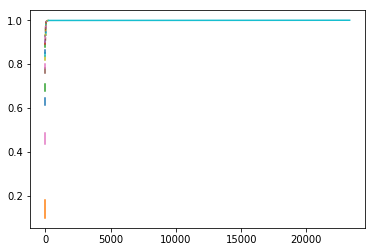

In [24]:
Helpful_Votes_Scaled = skewed_to_linear(50, df.Helpful_Votes, logspace=True, show_graph=True, print_arrays=True)

In [25]:
# Check difference between first a tenth of a percentile for non-skew and skew parts of graph
print ("Non-skew difference between a tenth of a percentile",(Helpful_Votes_Scaled.quantile(.8) - Helpful_Votes_Scaled.quantile(.799)),".")
print ("Skewed difference between a tenth of a percentile point",(Helpful_Votes_Scaled.quantile(1) - Helpful_Votes_Scaled.quantile(.999)),".")

Non-skew difference between a tenth of a percentile 1.1102230246251565e-16 .
Skewed difference between a tenth of a percentile point 0.0010308983604782052 .


#### Percentage_Helpful_Reviews

A review that receives more helpful votes because the book is popular is not necessarily more helpful than reviews for books that are less popular. In addition to Helpful_Votes_Scaled, and Helpful_Percentage, I add one last piece, Percentage_Helpful_Reviews. The purpose of this series is to acknowledge reviews that have accrued the majority of helpful votes per book. For instance, the 10th best Harry Potter review is not necessarily more helpful than the best review of some obscure poetry book that has received half of the helpful votes.

In [26]:
# Create column that sums helpful votes per book
Helpful_Votes_Book = df.groupby('asin')['Helpful_Votes'].transform('sum')

# Create series that de
Percentage_Helpful_Reviews = (df['Helpful_Votes']/Helpful_Votes_Book).fillna(0)

# Show new series
Percentage_Helpful_Reviews.describe()

count    4.756338e+06
mean     7.477917e-02
std      1.397735e-01
min      0.000000e+00
25%      3.267974e-03
50%      1.776650e-02
75%      7.692308e-02
max      1.000000e+00
Name: Helpful_Votes, dtype: float64

Note that the new series is not scaled efficiently. Since it's a right skewed distribution, I will take the log.

After some trial and error, using e-1 as a guide, I came up with the following formula.

In [27]:
import math
# Adjusted formula for Percentage_Helpful_Reviews
Percentage_Helpful_Reviews = np.log(Percentage_Helpful_Reviews + math.exp(1)-1)

# Show updated series
Percentage_Helpful_Reviews.describe()

count    4.756338e+06
mean     5.812982e-01
std      6.996599e-02
min      5.413249e-01
25%      5.432249e-01
50%      5.516115e-01
75%      5.851192e-01
max      1.000000e+00
Name: Helpful_Votes, dtype: float64

This log distribution ensures that reviewers are not penalized if they do not have a large percentage of the total helpful reviews, while reviewers whose percentage of helpful reviews are a large percentage of the total are rewarded.

#### Helpful_Rating Formula

First, I will look at the quartiles between the three relevent series.

In [30]:
Helpful_Votes_Scaled.describe()

count    4.756338e+06
mean     5.572892e-01
std      2.661728e-01
min      0.000000e+00
25%      4.345601e-01
50%      6.118928e-01
75%      7.588114e-01
max      1.000000e+00
dtype: float64

In [31]:
df['Helpful_Percentage'].describe()

count    4.756338e+06
mean     7.348979e-01
std      3.426306e-01
min      0.000000e+00
25%      5.000000e-01
50%      9.333333e-01
75%      1.000000e+00
max      1.000000e+00
Name: Helpful_Percentage, dtype: float64

In [32]:
Percentage_Helpful_Reviews.describe()

count    4.756338e+06
mean     5.812982e-01
std      6.996599e-02
min      5.413249e-01
25%      5.432249e-01
50%      5.516115e-01
75%      5.851192e-01
max      1.000000e+00
Name: Helpful_Votes, dtype: float64

In [33]:
# Declare helpful votes standard deviation
hv_std = 0.26

# Declare helpful percentage standard deviation
hp_std = 0.34

# Declare helpful percentage book score standard deviation
hpbs_std = 0.007

# Place all standard deviations into array
stds = np.array([0.26, 0.34, 0.007])

# Multiply by constant to get close to 1
stds = stds * 1.65

# Display sum of scaled array
print(stds.sum())

# Display new array
print(stds)

1.00155
[0.429   0.561   0.01155]


In [34]:
# Choose percentages by rounding down
hvp = 0.42
hpp = 0.56
hbp = 0.02

In [35]:
# Create weighted helpful score
df['Helpful_Rating'] = 0.42*Helpful_Votes_Scaled + 0.56*df['Helpful_Percentage'] + 0.02*Percentage_Helpful_Reviews

I spent some time checking tables and tweaking the weights. I made additional adjustments after deciding that I would train/ test on a smaller subset with a minimum number of total reviews.

In [36]:
df['Helpful_Votes_Scaled'] = Helpful_Votes_Scaled
df['Percentage_Helpful_Reviews'] = Percentage_Helpful_Reviews

#### Display Results

In [37]:
# Display dataframe with top helpful scores.
df.sort_values(by = ['Helpful_Rating'], ascending=False)

,index,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Helpful_Votes,Total_Votes,Helpful_Percentage,Review_Length,Sentence_Length,Word_Length,Helpful_Rating,Helpful_Votes_Scaled,Helpful_Percentage_Book_Score
3946146,7172732,1887169091,"[239, 239]",5.0,I looked through a lot of other planners while...,"06 18, 2000",A1D5O66Z92WXVT,"Kim Unertl ""kimz0519""","A real planning tool, finally!",961286400,239,239,1.000000,1507,16.000000,4.319703,0.999481,0.998982,0.995429
866465,1507296,0321034236,"[472, 472]",5.0,After receiving this textbook for my third lev...,"10 4, 2000",A2XOCQ0Q4169QG,allison taylor,really comprehensive text for flat patternmaking,970617600,472,472,1.000000,3969,27.772727,5.290164,0.999386,0.999045,0.989346
3986461,7236584,1932183795,"[195, 195]",5.0,This is exactly what I was looking for. A thre...,"02 20, 2007",AK8L2GQYMK6EH,Lori,this is a must have,1171929600,195,195,1.000000,1567,17.823529,4.096346,0.999216,0.998401,0.994410
3162573,5671237,1469969238,"[154, 154]",5.0,Ten percent of the books I have reviewed here ...,"10 17, 2013",A1S8AJIUIO6M9K,Robert David STEELE Vivas,SIX Stars -- A National Enema with Champagne,1381968000,154,154,1.000000,2463,25.312500,4.982278,0.998754,0.997695,0.986108
2541565,4461785,0972222030,"[153, 153]",5.0,"""SHARPE'S EAGLE wasn't written in a hurry. I h...","01 25, 2008",A2FEE88JZLDLXZ,"H. S. Wedekind ""Mr. Weekend""",A Small (115 pp.)Treasure...,1201219200,153,153,1.000000,2034,20.764706,4.647564,0.998606,0.997664,0.979351
283849,511607,0071350993,"[128, 128]",5.0,"Ordinarily,I would not get too excited about a...","09 1, 2002",A232QZUII76IGD,Ron Chappell,The definitive Cruising Book?,1030838400,128,128,1.000000,2552,19.347826,4.656751,0.998411,0.996880,0.986073
2479965,4372259,0912511060,"[232, 232]",5.0,I hate math. Memories of trying to understand ...,"07 21, 2001",A14Q14AJC3NUEW,slomamma,Fun ways to help your children love math,995673600,232,232,1.000000,2431,18.080000,4.275168,0.998397,0.998890,0.943166
2320720,4111733,0811836983,"[133, 133]",5.0,"I teach yoga to people of all ages, including ...","07 4, 2004",A10S7XWHFLH1TK,Vanessa Bradley,A wonderful gift for creative play!,1088899200,133,133,1.000000,3256,13.731707,4.609403,0.998384,0.997037,0.981435
3685182,6687162,1593853319,"[130, 130]",5.0,1. What makes James Morrison's books special t...,"08 25, 2006",A1XGX28KW1UPL9,Wolfgang Schlage,Wonderful Book,1156464000,130,130,1.000000,5882,17.413793,4.715726,0.998285,0.996943,0.978443
3551808,6483552,1571103562,"[162, 162]",5.0,As a middle school Reading teacher for 14 year...,"10 22, 2004",A1E9KCJ6C9O2Q,"Reading teacher ""jojomitty""",a MUST for all teachers!,1098403200,162,162,1.000000,1106,17.000000,4.353234,0.998275,0.997946,0.956867


In [38]:
helpfulRating = df.sort_values(by = ['Helpful_Rating'], ascending=False)
helpfulRating_topTen = helpfulRating[0:10]
helpfulRating_topTen.to_csv('helpfulRating_TopTen')

In [39]:
# Display dataframe with top helpful scores.
df.sort_values(by = ['Helpful_Votes'], ascending=False)

,index,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Helpful_Votes,Total_Votes,Helpful_Percentage,Review_Length,Sentence_Length,Word_Length,Helpful_Rating,Helpful_Votes_Scaled,Helpful_Percentage_Book_Score
979458,1703197,0345803485,"[23311, 24212]",2.0,I really don't like writing bad reviews. I adm...,"04 15, 2012",A3JT5XR92IFRVL,meymoon,Did a teenager write this???,1334448000,23311,24212,0.962787,2365,15.500000,4.322430,0.972945,1.000000,0.689215
978684,1702370,0345803485,"[15906, 16596]",1.0,I enjoy erotica and heard so much about this b...,"03 25, 2012",A36P4L1N44HPJ4,DS from LA,Bestseller? Really???,1332633600,15906,16596,0.958424,3684,18.235294,4.663383,0.969478,0.999690,0.644563
978589,1702265,0345803485,"[10755, 11479]",3.0,"First, a disclaimer. I am a male senior citize...","03 7, 2012",A3AL42LC3J38GH,david shobin/thatch pond corp,An older man on truckling,1331078400,10755,11479,0.936928,1614,13.947368,4.950000,0.956705,0.999475,0.612283
589075,993231,030746363X,"[7136, 7681]",1.0,Most of the 5-star reviews for 4HB came up on ...,"02 22, 2011",A1UXGNUAJUQ409,N. Watson,"4 Hour Baloney, save your money",1298332800,7136,7681,0.929046,5798,15.090909,4.744090,0.957239,0.999324,0.862878
978696,1702382,0345803485,"[6083, 6463]",1.0,I downloaded the book to my Kindle because it ...,"03 6, 2012",AFD4XKQMOY3NV,Ebeth822,"Not the worst I've ever read... No, wait. It IS.",1330992000,6083,6463,0.941204,1630,7.119048,4.298969,0.958413,0.999279,0.582075
631590,1071315,0307913090,"[5057, 5302]",5.0,"First off, I'm a heavy duty fan of GRRM. I've ...","05 9, 2001",A1AFXJ8U72MD6L,"MISTER SJEM ""sonofhotpie""","Well plotted and paced; excellent, fresh fanta...",989366400,5057,5302,0.953791,5428,16.929825,4.467021,0.968274,0.999237,0.723604
3070590,5475363,1455121924,"[4826, 4929]",5.0,I've been following Dr. Davis' heart scan blog...,"09 2, 2011",A2RASBRFD6V0II,Robert Burton Robinson - Author of the Ginger...,"Overweight? Diabetic? Got High Blood Pressure,...",1314921600,4826,4929,0.979103,9439,11.686667,4.257762,0.982831,0.999227,0.742888
2014053,3528854,074356619X,"[4415, 4913]",1.0,Catchy review title? Thought so. Robert Cial...,"03 6, 2007",A1WROCCXSM1542,"longhorn24 ""longhorn24""","The Review ""They"" Don't Want You To Read",1173139200,4415,4913,0.898636,5101,23.257143,5.147685,0.936974,0.999210,0.703505
979771,1703529,0345803485,"[4265, 4641]",1.0,"1.5 starsI don't enjoy writing bad reviews, ho...","02 3, 2012",A196E4Y4DSABN1,RiverinaRomantics,Could not finish,1328227200,4265,4641,0.918983,1809,15.500000,3.861972,0.945697,0.999203,0.570069
3876560,7049341,1619530953,"[3917, 4077]",5.0,"I didn't know how well I'd enjoy this book, se...","12 17, 2013",A1C3QC8IYNJLJ0,A. Norris,"Easiest Coloring Book, Ever!",1387238400,3917,4077,0.960755,151,9.333333,4.107143,0.973847,0.999189,0.808221


In [40]:
helpfulVotes = df.sort_values(by = ['Helpful_Votes'], ascending=False)
helpfulVotes_topTen = helpfulVotes[0:10]
helpfulVotes_topTen.to_csv('helpfulVotes_TopTen')

In [41]:
df.Helpful_Rating.describe()

count    4.756338e+06
mean     6.572302e-01
std      2.709052e-01
min      1.082650e-02
25%      5.505382e-01
50%      7.534652e-01
75%      8.284249e-01
max      9.994812e-01
Name: Helpful_Rating, dtype: float64

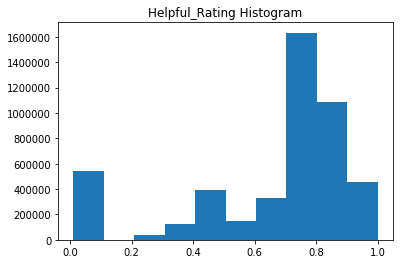

In [42]:
plt.hist(df.Helpful_Rating, bins=10)
plt.title('Helpful_Rating Histogram')
plt.show()

## Ouput Columns

In [43]:
# Define function to populate column
def badge(row):
    if row['Helpful_Rating']<0.10:
        return 1 #'Rewrite'
    if row['Helpful_Rating']<0.40:
        return 2 #'Unhelpful'
    elif row['Helpful_Rating']<0.75:
        return 3 #'Unclear'
    elif row['Helpful_Rating']<0.95:
        return 4 #'Helpful'
    elif row['Helpful_Rating']<0.99:
        return 5 #'Amazing'
    else:
        return 6 #'Superlative'
    
df['Badge'] = df.apply(badge, axis=1)

In [44]:
# Define function to populate column
def helpful_binary(row):
    if row['Helpful_Rating'] < 0.75:
        return 0
    else:
        return 1
    
df['Helpful'] = df.apply(helpful_binary, axis=1)

In [ ]:
# Define function to populate column
def star_ranking(row):
    if (row['overall'] == 4.0) | (row['overall']==5.0):
        return 1
    else:
        return 0
    
df['like'] = df.apply(star_ranking, axis=1)

In [48]:
df.head()

,index,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,...,Total_Votes,Helpful_Percentage,Review_Length,Sentence_Length,Word_Length,Helpful_Rating,Helpful_Votes_Scaled,Helpful_Percentage_Book_Score,Badge,Helpful?
0,1,000100039X,"[0, 2]",5.0,This is one my must have books. It is a master...,"12 11, 2003",A2S166WSCFIFP5,"adead_poet@hotmail.com ""adead_poet@hotmail.com""",close to god,1071100800,...,2,0.000000,268,9.800000,4.306122,0.010826,0.000000,0.541325,1,0
1,4,000100039X,"[7, 9]",5.0,A timeless classic. It is a very demanding an...,"10 7, 2002",A2XQ5LZHTD4AFT,Alaturka,A Modern Rumi,1033948800,...,9,0.777778,813,13.818182,4.260000,0.797675,0.836220,0.545366,4,1
2,14,000100039X,"[1, 1]",5.0,I discovered The Prophet fifty years ago in co...,"01 23, 2013",A19N3FCQCLJYUA,Amazon Customer,A book everyone &#34;should&#34; read,1358899200,...,1,1.000000,870,18.111111,4.148148,0.753353,0.434560,0.541903,4,1
3,15,000100039X,"[1, 1]",5.0,Can't say enough about Kahlil Gibran's work am...,"06 27, 2012",A3FFNE1DR5SI1W,A. Morelli,phenomenal piece of literature!,1340755200,...,1,1.000000,427,11.833333,4.845070,0.753353,0.434560,0.541903,4,1
4,17,000100039X,"[3, 5]",5.0,"Anything I've read by Gibran is, in my mind, f...","11 16, 2005",A2X4HE21JTAL98,Antiquarian,Flawless,1132099200,...,5,0.600000,485,16.000000,4.775000,0.631986,0.678869,0.543059,3,0


In [46]:
df_5 = df[df['Total_Votes']>4]
df_10 = df[df['Total_Votes']>9]

## Save Files

In [47]:
df.to_csv('df.csv')
df_5.to_csv('df_5.csv')
df_10.to_csv('df_10.csv')